## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import time

from sklearn.model_selection import train_test_split

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Generating data

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
int2bin = lambda n, width: np.array(list(np.binary_repr(n, width)), dtype=np.int32)

def generate_dataset(size=1000, width=None, concat=False):
    if width is None:
        width = int(np.ceil(np.log2(size)))
    max_int = 2**(width-1)

    ints = np.arange(max_int)
    n1 = np.random.permutation(ints)
    n2 = np.random.permutation(ints)
    
    if concat:
        X = np.zeros((size, width*2), dtype=np.int32)
    else:
        X = np.zeros((size, width, 2), dtype=np.int32)
    Y = np.zeros((size, width))
    
    for i, ns in enumerate(zip(n1, n2)):
        a,b = ns
        if concat:
            X[i] = np.concatenate((int2bin(a, width), int2bin(b, width)))
        else:
            X[i] = np.vstack((int2bin(a, width), int2bin(b, width))).T
        Y[i] = int2bin(a+b, width)
        if i+1==size:break
    return X,Y

In [50]:
bin_size = 12

X, Y = generate_dataset(10000, bin_size, concat=True)
X_train, X_valid, y_train, y_valid = train_test_split(X,Y)

## First: Linear Regression
<img src="http://www.biostathandbook.com/pix/regressionlollipop.gif">

In [7]:
reset_graph()

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size*2])
    Y = tf.placeholder(tf.float32, [None, bin_size])
    
    theta = tf.Variable(
        tf.random_normal(shape=[bin_size*2, bin_size])
    )
    bias = tf.Variable(
        tf.zeros(shape=[bin_size])
    )
    
    pred = tf.add(tf.matmul(X,theta),bias)
    loss = tf.reduce_mean(tf.abs(Y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(Y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    init = tf.global_variables_initializer()

In [8]:
def run_session(graph, loss_func="MAE"):
    reset_graph()

    start = time.time()
    with tf.Session(graph=graph) as sess:
        init.run()
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {X:X_train, Y:y_train}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {X:X_valid, Y:y_valid}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Valid {5}: {3}\n
                        Valid MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
    print("Took:",time.time()-start)
    return training, testing, training_mse, testing_mse

In [9]:
def plot_results(training, testing, training_mse, testing_mse, loss_func="MAE"):
    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(training.keys())
    data1 = [training[i] for i in xticks]
    data2 = [testing[i] for i in xticks]
    data3 = [training_mse[i] for i in xticks]
    data4 = [testing_mse[i] for i in xticks]

    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(loss_func)
    ax1.plot(xticks, data1, color=color1)
    ax1.plot(xticks, data2, color=color2)
    ax1.tick_params(axis='y')

    ax1.legend(["Train %s"%loss_func, "Valid %s"%loss_func])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:red'
    color2 = 'yellow'
    ax2.set_ylabel('MSE')
    ax2.plot(xticks, data3, color=color1)
    ax2.plot(xticks, data4, color=color2)
    ax2.tick_params(axis='y')
    ax2.legend(["Train MSE", "Valid MSE"], loc=9)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [10]:
training, testing, training_mse, testing_mse = run_session(graph, "MAE")

Epoch 0

                        Train MAE: 0.5532146692276001

                        Train MSE: 2.321143865585327

                        Valid MAE: 0.5234771966934204

                        Valid MSE: 2.1720495223999023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train MAE: 0.26379814743995667

                        Train MSE: 0.45381906628608704

                        Valid MAE: 0.25399431586265564

                        Valid MSE: 0.4335823059082031
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train MAE: 0.14561130106449127

                        Train MSE: 0.155385822057724

                        Valid MAE: 0.13983704149723053

                        Valid MSE: 0.14741908013820648
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train MAE: 0.10665525496006012

                        Train MSE: 0.07029620558023453

                        Valid MAE: 0.10204462707042694

   

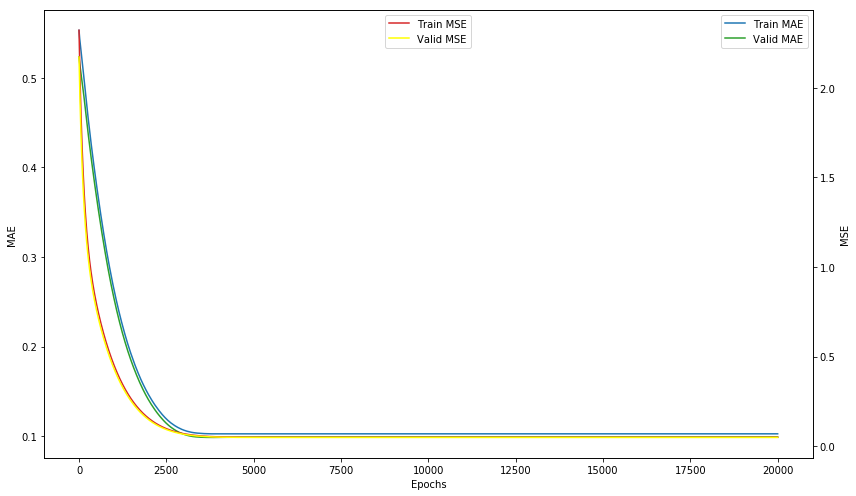

In [11]:
plot_results(training, testing, training_mse, testing_mse, "MAE")

## Second: Single-Layer Perceptron
<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

In [12]:
reset_graph()


graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    Y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    def model(data):
        return tf.add(tf.matmul(data,w),b)
    
    logits = model(X)
    pred = tf.nn.sigmoid(logits)
    loss = tf.reduce_mean(tf.abs(Y-pred))
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(Y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    init = tf.global_variables_initializer()

In [13]:
training, testing, training_mse, testing_mse = run_session(graph, "MAE")

Epoch 0

                        Train MAE: 0.49964210391044617

                        Train MSE: 0.27592629194259644

                        Valid MAE: 0.4979388117790222

                        Valid MSE: 0.2728750705718994
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train MAE: 0.31312990188598633

                        Train MSE: 0.1309584230184555

                        Valid MAE: 0.3142509460449219

                        Valid MSE: 0.131265327334404
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train MAE: 0.20234031975269318

                        Train MSE: 0.08202844113111496

                        Valid MAE: 0.2043679654598236

                        Valid MSE: 0.08391793817281723
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train MAE: 0.1450507640838623

                        Train MSE: 0.06691788136959076

                        Valid MAE: 0.14687304198741913

   

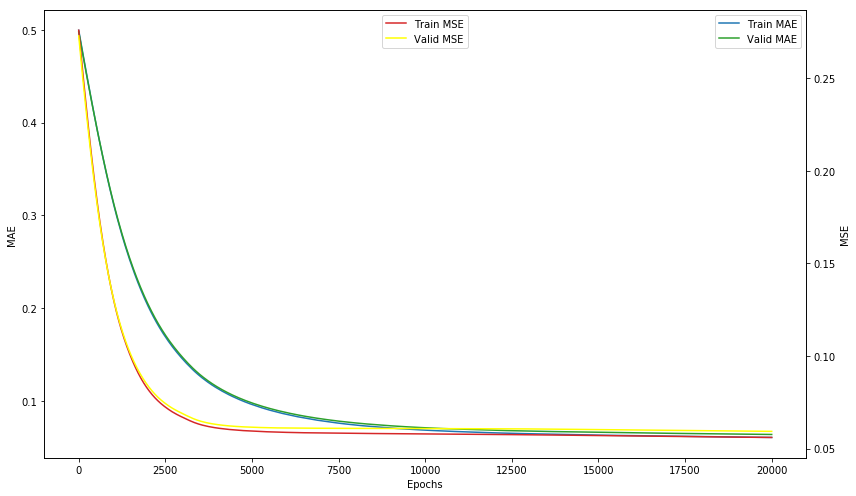

In [14]:
plot_results(training, testing, training_mse, testing_mse, "MAE")

### Third: Feedforward NN (no recurrence yet)

In [15]:
def run_session_rnn(graph, saver, loss_func="MAE", epochs=100, p_every=1, FF=False, path="binary_addition_ff"):
    start = time.time()
    reset_graph()
    with tf.Session(graph=graph) as sess, tf.device('/gpu'):
        init.run()
        train_maes = dict()
        valid_maes = dict()
        train_mses = dict()
        valid_mses = dict()
        
        
        for e in range(epochs+1):
            
            feed_dict = {y: y_train}
            if FF:
                feed_dict.update({x1:X1_train, x2:X2_train})
            else:
                feed_dict.update({X:X_train})

            _, mae_val_train, mse_val_train = sess.run(
                [optimizer, loss, mse], feed_dict=feed_dict)
            
            feed_dict = {y: y_valid}
            if FF:
                feed_dict.update({x1:X1_valid, x2:X2_valid})
            else:
                feed_dict.update({X:X_valid})
            
            mae_val_valid, mse_val_valid = sess.run([loss, mse], feed_dict=feed_dict)
            if e%p_every==0:
                print("Epoch: {0}\nTrain MAE:{1}\nValid MAE: {2}\nTrain MSE:{3}\nValid MSE:{4}".format(
                e,mae_val_train, mae_val_valid, mse_val_train, mse_val_valid))
                print("~"*50)
                train_maes[e] = mae_val_train
                train_mses[e] = mse_val_train
                
                valid_maes[e] = mae_val_valid
                valid_mses[e] = mse_val_valid
        
            if e%(p_every*10)==0:
                saver.save(sess, './{}'.format(path))
        print("Took: ", time.time()-start)
        return train_maes, train_mses, valid_maes, valid_mses, saver

In [61]:
def print_results(graph, saver, n=10, path="./binary_addition_ff", FF=False, scales=False, activate=False):    
    with tf.Session(graph=graph) as sess:
        saver.restore(sess, path)
        _ = 0
        while _ < n:
            i = np.random.randint(len(X1_valid))
            y_ = y_valid[i].astype(np.int32)
            if sum(y_) == 0:
                continue
            _ += 1
            
            if FF:
                x1_ = X1_valid[i]
                x2_ = X2_valid[i]
                feed_dict = {x1:[x1_], x2:[x2_]}
            else:
                feed_dict = {X: [X_valid[i]]}
                
            ps = sess.run(pred,feed_dict=feed_dict)
        
            ps = np.reshape(ps, (-1))

            if activate:
                rounded = np.array(ps>=0).astype(np.int32)
            else:
                rounded = np.round(ps)
            if scales:
                rounded = int2bin(int(rounded), X_valid.shape[1])
                y_ = int2bin(int(y_), X_valid.shape[1])

            bin2int = lambda x: sum([2**i*n for i,n in enumerate(np.flip(x,0))])
            
            if not FF:
                x1_ = X_valid[i].T[0]
                x2_ = X_valid[i].T[1]
            a = bin2int(x1_)
            b = bin2int(x2_)
            c = bin2int(y_)
            d = bin2int(rounded)
            print(a, x1_)
            print("+")
            print(b, x2_)
            print("=")
            print("True:",c, y_)
            print("Pred:",d, rounded)
            print("~"*10)

In [51]:
X1_train = X_train[:, :X_train.shape[1]//2]
X2_train = X_train[:, X_train.shape[1]//2:]

X1_valid = X_valid[:, :X_valid.shape[1]//2]
X2_valid = X_valid[:, X_valid.shape[1]//2:]

In [52]:
reset_graph()


graph_ff = tf.Graph()

with graph_ff.as_default():
    x1 = tf.placeholder(tf.float32, [None, bin_size])
    x2 = tf.placeholder(tf.float32, [None, bin_size])
    y = tf.placeholder(tf.float32, [None, bin_size])
    
    W1 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    W2 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    b = tf.Variable(tf.random_normal([bin_size]))
    
    predictions = tf.nn.sigmoid(tf.add(tf.add(tf.matmul(x1, W1), tf.matmul(x2, W2)), b))
    
    loss = tf.reduce_mean(tf.abs(y - predictions))
    
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions))
    
    optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    pred = tf.round(predictions)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [19]:
training, testing, training_mse, testing_mse, saver_ff = run_session_rnn(
    graph_ff, saver, FF=True, epochs=10000, p_every=50)

Epoch: 0
Train MAE:0.4640491008758545
Valid MAE: 0.46231088042259216
Train MSE:0.2811630070209503
Valid MSE:0.2779898941516876
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 50
Train MAE:0.45590755343437195
Valid MAE: 0.45412197709083557
Train MSE:0.2716047167778015
Valid MSE:0.26860401034355164
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 100
Train MAE:0.44786033034324646
Valid MAE: 0.4460621774196625
Train MSE:0.2622978091239929
Valid MSE:0.25948742032051086
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 150
Train MAE:0.44001007080078125
Valid MAE: 0.43820691108703613
Train MSE:0.2533135414123535
Valid MSE:0.25073567032814026
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 200
Train MAE:0.43233588337898254
Valid MAE: 0.4305788278579712
Train MSE:0.24476704001426697
Valid MSE:0.24245840311050415
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 250
Train MAE:0.4247627556324005
Valid MAE: 0.423112154006958
Train MSE:0.236736357212066

Epoch: 2300
Train MAE:0.22935789823532104
Valid MAE: 0.2276078462600708
Train MSE:0.07971880584955215
Valid MSE:0.07915060222148895
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2350
Train MAE:0.22677107155323029
Valid MAE: 0.22499485313892365
Train MSE:0.078487329185009
Valid MSE:0.07790670543909073
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2400
Train MAE:0.22424863278865814
Valid MAE: 0.22244670987129211
Train MSE:0.07731848955154419
Valid MSE:0.07672765105962753
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2450
Train MAE:0.22180555760860443
Valid MAE: 0.21997235715389252
Train MSE:0.07620704919099808
Valid MSE:0.075612872838974
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2500
Train MAE:0.21941731870174408
Valid MAE: 0.21756511926651
Train MSE:0.07515572756528854
Valid MSE:0.07455035299062729
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2550
Train MAE:0.2171151041984558
Valid MAE: 0.2152196168899536
Train MSE:0.07415

Epoch: 4600
Train MAE:0.15919652581214905
Valid MAE: 0.15679414570331573
Train MSE:0.05677700787782669
Valid MSE:0.05611705780029297
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4650
Train MAE:0.15837043523788452
Valid MAE: 0.1559644490480423
Train MSE:0.05663105845451355
Valid MSE:0.05597288906574249
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4700
Train MAE:0.15756186842918396
Valid MAE: 0.15514619648456573
Train MSE:0.05649011582136154
Valid MSE:0.05583415552973747
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4750
Train MAE:0.15676887333393097
Valid MAE: 0.1543494313955307
Train MSE:0.05635508894920349
Valid MSE:0.05569995939731598
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4800
Train MAE:0.15600168704986572
Valid MAE: 0.15357063710689545
Train MSE:0.056226085871458054
Valid MSE:0.05557037517428398
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4850
Train MAE:0.15524029731750488
Valid MAE: 0.1528048813343048
Train MSE

Epoch: 6900
Train MAE:0.13491016626358032
Valid MAE: 0.13231588900089264
Train MSE:0.05361553654074669
Valid MSE:0.05300915986299515
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6950
Train MAE:0.13460741937160492
Valid MAE: 0.1320127546787262
Train MSE:0.05359230563044548
Valid MSE:0.052985869348049164
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7000
Train MAE:0.13430652022361755
Valid MAE: 0.13172049820423126
Train MSE:0.05356832593679428
Valid MSE:0.052962612360715866
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7050
Train MAE:0.1340140998363495
Valid MAE: 0.13143138587474823
Train MSE:0.0535459890961647
Valid MSE:0.05294167250394821
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7100
Train MAE:0.1337418258190155
Valid MAE: 0.13114570081233978
Train MSE:0.05352485179901123
Valid MSE:0.05292098969221115
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7150
Train MAE:0.13347245752811432
Valid MAE: 0.13087190687656403
Train MSE

Epoch: 9200
Train MAE:0.12668867409229279
Valid MAE: 0.12405318766832352
Train MSE:0.05306847393512726
Valid MSE:0.052490949630737305
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9250
Train MAE:0.1266070008277893
Valid MAE: 0.12396754324436188
Train MSE:0.05306248739361763
Valid MSE:0.052486028522253036
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9300
Train MAE:0.12652286887168884
Valid MAE: 0.1238921582698822
Train MSE:0.053057823330163956
Valid MSE:0.05248153582215309
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9350
Train MAE:0.12645715475082397
Valid MAE: 0.12381389737129211
Train MSE:0.05305424705147743
Valid MSE:0.052477508783340454
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9400
Train MAE:0.12637968361377716
Valid MAE: 0.12373674660921097
Train MSE:0.05304824188351631
Valid MSE:0.05247320979833603
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9450
Train MAE:0.12630075216293335
Valid MAE: 0.12366445362567902
Train

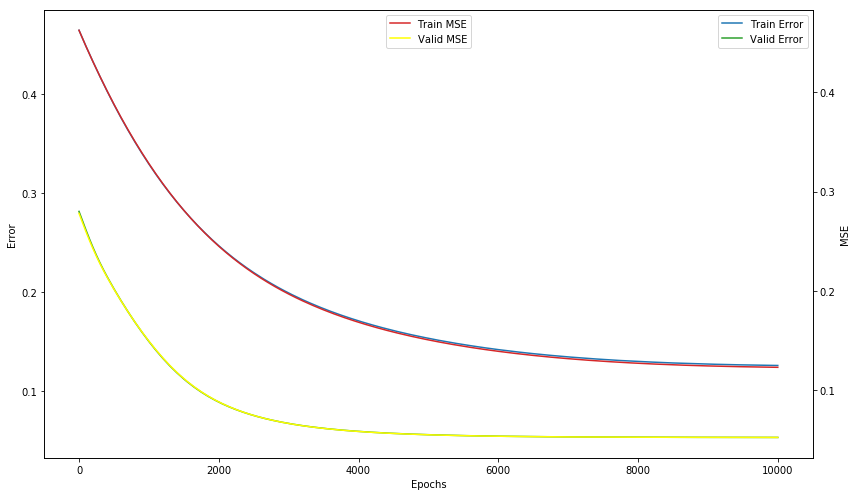

In [20]:
plot_results(training, testing, training_mse, testing_mse, "MAE")

In [53]:
print_results(graph_ff, saver_ff, FF=True)

INFO:tensorflow:Restoring parameters from ./binary_addition_ff
1527 [0 1 0 1 1 1 1 1 0 1 1 1]
+
1571 [0 1 1 0 0 0 1 0 0 0 1 1]
=
True: 3098 [1 1 0 0 0 0 0 1 1 0 1 0]
Pred: 4095.0 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
~~~~~~~~~~
1311 [0 1 0 1 0 0 0 1 1 1 1 1]
+
1921 [0 1 1 1 1 0 0 0 0 0 0 1]
=
True: 3232 [1 1 0 0 1 0 1 0 0 0 0 0]
Pred: 3542.0 [1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]
~~~~~~~~~~
631 [0 0 1 0 0 1 1 1 0 1 1 1]
+
1706 [0 1 1 0 1 0 1 0 1 0 1 0]
=
True: 2337 [1 0 0 1 0 0 1 0 0 0 0 1]
Pred: 4095.0 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
~~~~~~~~~~
469 [0 0 0 1 1 1 0 1 0 1 0 1]
+
1868 [0 1 1 1 0 1 0 0 1 1 0 0]
=
True: 2337 [1 0 0 1 0 0 1 0 0 0 0 1]
Pred: 3327.0 [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
~~~~~~~~~~
195 [0 0 0 0 1 1 0 0 0 0 1 1]
+
854 [0 0 1 1 0 1 0 1 0 1 1 0]
=
True: 1049 [0 1 0 0 0 0 0 1 1 0 0 1]
Pred: 96.0 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
~~~~~~~~~~
1801 [0 1 1 1 0 0 0 0 1 0 0 1]
+
1326 [0 1 0 1 0 0 1 0 1 1 1 0]
=
True: 3127 [1 1 0 0 0 0 1 1 0 1 1 1]
Pred: 3464.0 [1

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>

In [56]:
bin_size = 12

X, Y = generate_dataset(10000, bin_size)
X_train, X_valid, y_train, y_valid = train_test_split(X,Y)

In [57]:
n_inputs = 2
h_size = 16

In [58]:
reset_graph()
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None, bin_size])  # num of instances, num of bins

    
    basic_cell = tf.contrib.rnn.GRUCell(num_units=h_size, activation=tf.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#     top_h_state = tf.reshape(states[-1], (-1, h_size))
#     pred = tf.layers.dense(top_h_state, bin_size)
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, 1)
    pred = tf.reshape(stacked_outputs, [-1, bin_size])
    
    loss = tf.reduce_mean(tf.abs(y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
#     optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [25]:
train_maes, train_mses, valid_maes, valid_mses, saver_gru = run_session_rnn(
    graph_rnn, saver, epochs=200, p_every=2, path="binary_addition_gru")

Epoch: 0
Train MAE:0.3502652645111084
Valid MAE: 0.3317186236381531
Train MSE:0.22362320125102997
Valid MSE:0.20659182965755463
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
Train MAE:0.3213222324848175
Valid MAE: 0.30280810594558716
Train MSE:0.20204778015613556
Valid MSE:0.18623138964176178
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
Train MAE:0.29238080978393555
Valid MAE: 0.27395087480545044
Train MSE:0.18238157033920288
Valid MSE:0.16775864362716675
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
Train MAE:0.26353222131729126
Valid MAE: 0.24515323340892792
Train MSE:0.16458900272846222
Valid MSE:0.15115296840667725
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8
Train MAE:0.2347407191991806
Valid MAE: 0.2164137065410614
Train MSE:0.1486567109823227
Valid MSE:0.1364092230796814
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10
Train MAE:0.20599092543125153
Valid MAE: 0.1883092224597931
Train MSE:0.13458892703056335
Va

Epoch: 94
Train MAE:0.10444646328687668
Valid MAE: 0.09991101920604706
Train MSE:0.09536870568990707
Valid MSE:0.09139862656593323
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 96
Train MAE:0.10427789390087128
Valid MAE: 0.09977494925260544
Train MSE:0.09523562341928482
Valid MSE:0.09137138724327087
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 98
Train MAE:0.10416564345359802
Valid MAE: 0.09967420250177383
Train MSE:0.09528815001249313
Valid MSE:0.09135955572128296
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 100
Train MAE:0.10406804829835892
Valid MAE: 0.09954138100147247
Train MSE:0.09521741420030594
Valid MSE:0.0913744792342186
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 102
Train MAE:0.10390900820493698
Valid MAE: 0.09944257885217667
Train MSE:0.09531137347221375
Valid MSE:0.09145838767290115
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 104
Train MAE:0.10385019332170486
Valid MAE: 0.09938306361436844
Train MSE:0.09522

Epoch: 186
Train MAE:0.1037469431757927
Valid MAE: 0.09951178729534149
Train MSE:0.09465012699365616
Valid MSE:0.09096681326627731
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 188
Train MAE:0.10366371273994446
Valid MAE: 0.0991925299167633
Train MSE:0.09467419981956482
Valid MSE:0.09080421179533005
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 190
Train MAE:0.10406548529863358
Valid MAE: 0.09916023910045624
Train MSE:0.09487007558345795
Valid MSE:0.09082142263650894
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 192
Train MAE:0.10371358692646027
Valid MAE: 0.10005080699920654
Train MSE:0.09465642273426056
Valid MSE:0.09108324348926544
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 194
Train MAE:0.10419179499149323
Valid MAE: 0.09998801350593567
Train MSE:0.09489660710096359
Valid MSE:0.09062207490205765
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 196
Train MAE:0.10453969240188599
Valid MAE: 0.09933346509933472
Train MSE:0.094

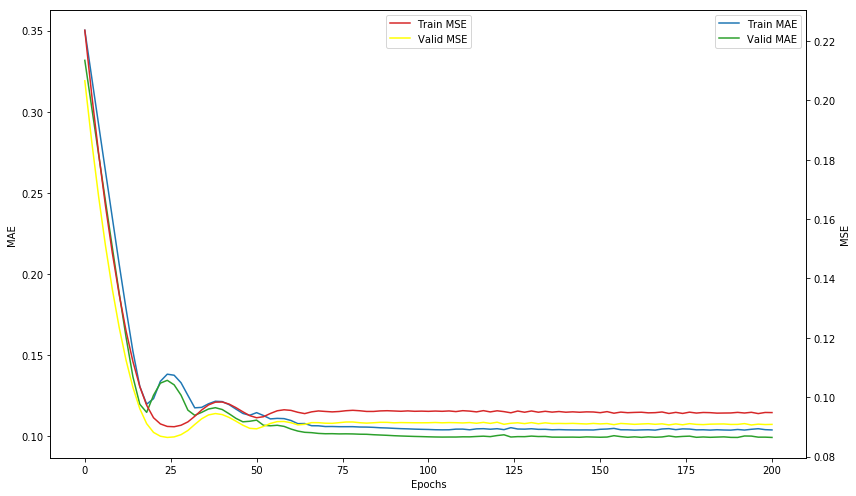

In [26]:
plot_results(train_maes, valid_maes, train_mses, valid_mses, "MAE")

In [62]:
print_results(graph_rnn, saver_gru, path="./binary_addition_gru", activate=True)

INFO:tensorflow:Restoring parameters from ./binary_addition_gru
1366 [0 1 0 1 0 1 0 1 0 1 1 0]
+
1358 [0 1 0 1 0 1 0 0 1 1 1 0]
=
True: 2724 [1 0 1 0 1 0 1 0 0 1 0 0]
Pred: 2047 [0 1 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
56 [0 0 0 0 0 0 1 1 1 0 0 0]
+
414 [0 0 0 1 1 0 0 1 1 1 1 0]
=
True: 470 [0 0 0 1 1 1 0 1 0 1 1 0]
Pred: 1023 [0 0 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
1834 [0 1 1 1 0 0 1 0 1 0 1 0]
+
1786 [0 1 1 0 1 1 1 1 1 0 1 0]
=
True: 3620 [1 1 1 0 0 0 1 0 0 1 0 0]
Pred: 2047 [0 1 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
1407 [0 1 0 1 0 1 1 1 1 1 1 1]
+
1284 [0 1 0 1 0 0 0 0 0 1 0 0]
=
True: 2691 [1 0 1 0 1 0 0 0 0 0 1 1]
Pred: 2047 [0 1 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
827 [0 0 1 1 0 0 1 1 1 0 1 1]
+
1744 [0 1 1 0 1 1 0 1 0 0 0 0]
=
True: 2571 [1 0 1 0 0 0 0 0 1 0 1 1]
Pred: 2047 [0 1 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
1366 [0 1 0 1 0 1 0 1 0 1 1 0]
+
1358 [0 1 0 1 0 1 0 0 1 1 1 0]
=
True: 2724 [1 0 1 0 1 0 1 0 0 1 0 0]
Pred: 2047 [0 1 1 1 1 1 1 1 1 1 1 1]
~~~~~~~~~~
1262 [0 1 0 0 1 1 1 0 1 1 1 0]
+
12

### Using ouputs as scalars instead of binary sequences

In [28]:
bin2int_vec = np.array([2**i for i in range(bin_size-1,-1,-1)], dtype=np.float32)
train_Y_ints = np.dot(y_train, bin2int_vec)
test_Y_ints = np.dot(y_valid, bin2int_vec)

In [29]:
y_train = train_Y_ints.reshape(-1, 1)
y_valid = test_Y_ints.reshape(-1,1)

In [30]:
reset_graph()
graph_scaler = tf.Graph()
with graph_scaler.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None, 1])  # num of instances, num of bins

    
    basic_cell = tf.contrib.rnn.GRUCell(num_units=h_size, activation=tf.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, 1)
    pred_bin = tf.reshape(stacked_outputs, [-1, bin_size])

#     pred_bin = tf.layers.dense(top_h_state, bin_size, activation=tf.sigmoid)
    pred = tf.matmul(pred_bin, tf.reshape(bin2int_vec, [-1,1]))
    
    loss = tf.reduce_mean(tf.abs(y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, pred))
#     optimizer = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [32]:
train_maes, train_mses, valid_maes, valid_mses, scaler_saver = run_session_rnn(
    graph_scaler, saver, epochs=15000, p_every=20, path="binary_addition_scaler")

Epoch: 0
Train MAE:1376.900146484375
Valid MAE: 1370.2900390625
Train MSE:2049369.125
Valid MSE:2011189.625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 20
Train MAE:1032.3902587890625
Valid MAE: 1027.300537109375
Train MSE:1186498.25
Valid MSE:1167326.125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 40
Train MAE:790.1290893554688
Valid MAE: 785.1931762695312
Train MSE:857903.6875
Valid MSE:850748.25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 60
Train MAE:667.1259765625
Valid MAE: 663.3358764648438
Train MSE:782177.0625
Valid MSE:776680.8125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 80
Train MAE:630.3997192382812
Valid MAE: 628.5037231445312
Train MSE:750722.3125
Valid MSE:744796.8125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 100
Train MAE:624.2454833984375
Valid MAE: 622.9815063476562
Train MSE:720617.75
Valid MSE:715037.1875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 120
Train MAE:616.656494140625

Epoch: 980
Train MAE:16.6102352142334
Valid MAE: 15.573945045471191
Train MSE:1204.40478515625
Valid MSE:1015.6907958984375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1000
Train MAE:16.229488372802734
Valid MAE: 15.190067291259766
Train MSE:1157.517578125
Valid MSE:976.9442138671875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1020
Train MAE:15.878739356994629
Valid MAE: 14.834593772888184
Train MSE:1114.5748291015625
Valid MSE:941.5889282226562
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1040
Train MAE:15.550209999084473
Valid MAE: 14.49700927734375
Train MSE:1075.1417236328125
Valid MSE:909.1627807617188
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1060
Train MAE:15.243271827697754
Valid MAE: 14.184281349182129
Train MSE:1038.7213134765625
Valid MSE:879.2340698242188
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1080
Train MAE:14.954307556152344
Valid MAE: 13.892472267150879
Train MSE:1004.9019775390625
Valid MSE:851.

Epoch: 1920
Train MAE:7.80914306640625
Valid MAE: 7.109683036804199
Train MSE:356.3193359375
Valid MSE:302.23748779296875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1940
Train MAE:7.723293304443359
Valid MAE: 7.031707763671875
Train MSE:349.04473876953125
Valid MSE:296.13958740234375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1960
Train MAE:7.6375885009765625
Valid MAE: 6.954432964324951
Train MSE:341.9324035644531
Valid MSE:290.16448974609375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1980
Train MAE:7.553048133850098
Valid MAE: 6.878567218780518
Train MSE:334.9660949707031
Valid MSE:284.3122863769531
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2000
Train MAE:7.4685163497924805
Valid MAE: 6.802772521972656
Train MSE:328.1449890136719
Valid MSE:278.577392578125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2020
Train MAE:7.384905815124512
Valid MAE: 6.727322101593018
Train MSE:321.4607849121094
Valid MSE:272.96023559

Epoch: 2860
Train MAE:4.640388488769531
Valid MAE: 4.3385539054870605
Train MSE:131.30435180664062
Valid MSE:114.17678833007812
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2880
Train MAE:4.581366539001465
Valid MAE: 4.285304546356201
Train MSE:128.3258514404297
Valid MSE:111.68986511230469
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2900
Train MAE:4.518448829650879
Valid MAE: 4.223692417144775
Train MSE:125.39948272705078
Valid MSE:109.23186492919922
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2920
Train MAE:4.462492942810059
Valid MAE: 4.178527355194092
Train MSE:122.52249145507812
Valid MSE:106.83956146240234
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2940
Train MAE:4.405521392822266
Valid MAE: 4.123734951019287
Train MSE:119.69889068603516
Valid MSE:104.47488403320312
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2960
Train MAE:4.352008819580078
Valid MAE: 4.071622848510742
Train MSE:116.92530059814453
Valid MSE:10

Epoch: 3800
Train MAE:2.4163947105407715
Valid MAE: 2.3454573154449463
Train MSE:40.09114456176758
Valid MSE:37.03396987915039
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3820
Train MAE:2.3934969902038574
Valid MAE: 2.323866128921509
Train MSE:39.10232162475586
Valid MSE:36.177879333496094
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3840
Train MAE:2.379438638687134
Valid MAE: 2.310441017150879
Train MSE:38.165767669677734
Valid MSE:35.38166046142578
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3860
Train MAE:2.3635401725769043
Valid MAE: 2.2965497970581055
Train MSE:37.263877868652344
Valid MSE:34.609867095947266
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3880
Train MAE:2.346766710281372
Valid MAE: 2.283993721008301
Train MSE:36.38787841796875
Valid MSE:33.847496032714844
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3900
Train MAE:2.328498363494873
Valid MAE: 2.266058921813965
Train MSE:35.53635787963867
Valid MSE:33.

Epoch: 4720
Train MAE:1.7501102685928345
Valid MAE: 1.7103387117385864
Train MSE:15.582582473754883
Valid MSE:14.866059303283691
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4740
Train MAE:1.728503942489624
Valid MAE: 1.6887800693511963
Train MSE:15.295105934143066
Valid MSE:14.588996887207031
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4760
Train MAE:1.7042829990386963
Valid MAE: 1.6697206497192383
Train MSE:15.015181541442871
Valid MSE:14.32010269165039
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4780
Train MAE:1.6855288743972778
Valid MAE: 1.6523915529251099
Train MSE:14.740348815917969
Valid MSE:14.058368682861328
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4800
Train MAE:1.6661455631256104
Valid MAE: 1.6301864385604858
Train MSE:14.473931312561035
Valid MSE:13.798995018005371
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4820
Train MAE:1.6561782360076904
Valid MAE: 1.604580283164978
Train MSE:14.214643478393555
Val

Epoch: 5660
Train MAE:1.0418269634246826
Valid MAE: 0.9783377647399902
Train MSE:7.285549163818359
Valid MSE:6.799963474273682
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5680
Train MAE:1.023958444595337
Valid MAE: 0.9640045166015625
Train MSE:7.188977241516113
Valid MSE:6.705140590667725
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5700
Train MAE:1.024470329284668
Valid MAE: 0.9598732590675354
Train MSE:7.093971252441406
Valid MSE:6.613270282745361
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5720
Train MAE:1.0150108337402344
Valid MAE: 0.9430119395256042
Train MSE:7.000601768493652
Valid MSE:6.522385120391846
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5740
Train MAE:0.9972336292266846
Valid MAE: 0.937994122505188
Train MSE:6.909387588500977
Valid MSE:6.4338765144348145
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5760
Train MAE:1.002951741218567
Valid MAE: 0.9378717541694641
Train MSE:6.8192925453186035
Valid MSE:6.3

Epoch: 6600
Train MAE:0.7514404654502869
Valid MAE: 0.6961842775344849
Train MSE:4.041494846343994
Valid MSE:3.7127859592437744
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6620
Train MAE:0.7485945820808411
Valid MAE: 0.6975467801094055
Train MSE:3.9908292293548584
Valid MSE:3.665515661239624
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6640
Train MAE:0.7554078102111816
Valid MAE: 0.6915147304534912
Train MSE:3.941889762878418
Valid MSE:3.6216022968292236
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6660
Train MAE:0.75649094581604
Valid MAE: 0.6992296576499939
Train MSE:3.8944265842437744
Valid MSE:3.57559871673584
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6680
Train MAE:0.7380847930908203
Valid MAE: 0.6887139678001404
Train MSE:3.846092700958252
Valid MSE:3.53171443939209
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6700
Train MAE:0.7382915616035461
Valid MAE: 0.6796692609786987
Train MSE:3.7990267276763916
Valid MSE:

Epoch: 7520
Train MAE:0.5774157643318176
Valid MAE: 0.5402485728263855
Train MSE:2.3310012817382812
Valid MSE:2.1470370292663574
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7540
Train MAE:0.5669276118278503
Valid MAE: 0.522138774394989
Train MSE:2.3043336868286133
Valid MSE:2.1261446475982666
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7560
Train MAE:0.5530596375465393
Valid MAE: 0.5248660445213318
Train MSE:2.2783050537109375
Valid MSE:2.1004445552825928
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7580
Train MAE:0.5499908924102783
Valid MAE: 0.5246499180793762
Train MSE:2.2529265880584717
Valid MSE:2.0777206420898438
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7600
Train MAE:0.5503634214401245
Valid MAE: 0.5145502686500549
Train MSE:2.227919578552246
Valid MSE:2.0556387901306152
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7620
Train MAE:0.552001953125
Valid MAE: 0.5174310803413391
Train MSE:2.203385829925537
Valid M

Epoch: 8440
Train MAE:0.43619009852409363
Valid MAE: 0.4153619706630707
Train MSE:1.4555444717407227
Valid MSE:1.3742785453796387
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8460
Train MAE:0.43978482484817505
Valid MAE: 0.419939249753952
Train MSE:1.44204580783844
Valid MSE:1.3600034713745117
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8480
Train MAE:0.4337325990200043
Valid MAE: 0.41326162219047546
Train MSE:1.428945541381836
Valid MSE:1.3491021394729614
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8500
Train MAE:0.43386366963386536
Valid MAE: 0.4104505777359009
Train MSE:1.4160065650939941
Valid MSE:1.3401970863342285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8520
Train MAE:0.4341098964214325
Valid MAE: 0.4204081594944
Train MSE:1.4032961130142212
Valid MSE:1.3266011476516724
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8540
Train MAE:0.42934635281562805
Valid MAE: 0.40830865502357483
Train MSE:1.3907225131988525
V

Epoch: 9360
Train MAE:0.36024564504623413
Valid MAE: 0.34564241766929626
Train MSE:0.9735203385353088
Valid MSE:0.9420826435089111
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9380
Train MAE:0.35870012640953064
Valid MAE: 0.34405890107154846
Train MSE:0.9649967551231384
Valid MSE:0.934202253818512
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9400
Train MAE:0.3568268120288849
Valid MAE: 0.34247148036956787
Train MSE:0.9565703868865967
Valid MSE:0.9263755679130554
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9420
Train MAE:0.3553455173969269
Valid MAE: 0.3408491313457489
Train MSE:0.9481633305549622
Valid MSE:0.9186211228370667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9440
Train MAE:0.35366132855415344
Valid MAE: 0.3393917977809906
Train MSE:0.9398520588874817
Valid MSE:0.9109009504318237
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9460
Train MAE:0.35195812582969666
Valid MAE: 0.33783313632011414
Train MSE:0.9315829277

Epoch: 10280
Train MAE:0.2881663143634796
Valid MAE: 0.2803322970867157
Train MSE:0.6413699388504028
Valid MSE:0.6308331489562988
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10300
Train MAE:0.28682175278663635
Valid MAE: 0.27884647250175476
Train MSE:0.6354382634162903
Valid MSE:0.6253082156181335
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10320
Train MAE:0.28542038798332214
Valid MAE: 0.27755972743034363
Train MSE:0.6295856833457947
Valid MSE:0.6197518706321716
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10340
Train MAE:0.28391164541244507
Valid MAE: 0.27621224522590637
Train MSE:0.6237527132034302
Valid MSE:0.6142646074295044
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10360
Train MAE:0.2825487554073334
Valid MAE: 0.2751481831073761
Train MSE:0.6180009245872498
Valid MSE:0.6087589859962463
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10380
Train MAE:0.2810525894165039
Valid MAE: 0.27371302247047424
Train MSE:0.6123

Epoch: 11180
Train MAE:0.23154482245445251
Valid MAE: 0.22701509296894073
Train MSE:0.42415937781333923
Valid MSE:0.4237947165966034
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11200
Train MAE:0.23034806549549103
Valid MAE: 0.22588840126991272
Train MSE:0.4203186333179474
Valid MSE:0.419767826795578
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11220
Train MAE:0.23346982896327972
Valid MAE: 0.22936362028121948
Train MSE:0.42575958371162415
Valid MSE:0.42956244945526123
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11240
Train MAE:0.22853203117847443
Valid MAE: 0.22388745844364166
Train MSE:0.41291728615760803
Valid MSE:0.41243866086006165
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11260
Train MAE:0.2274644672870636
Valid MAE: 0.22308725118637085
Train MSE:0.40914610028266907
Valid MSE:0.4091959595680237
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11280
Train MAE:0.2265693098306656
Valid MAE: 0.22246569395065308
Train MS

Epoch: 12080
Train MAE:0.19563955068588257
Valid MAE: 0.19362500309944153
Train MSE:0.2990788519382477
Valid MSE:0.3028413653373718
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12100
Train MAE:0.19491590559482574
Valid MAE: 0.19258570671081543
Train MSE:0.2969582676887512
Valid MSE:0.29977139830589294
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12120
Train MAE:0.19421391189098358
Valid MAE: 0.19193816184997559
Train MSE:0.2949765920639038
Valid MSE:0.2976780831813812
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12140
Train MAE:0.19360053539276123
Valid MAE: 0.19140329957008362
Train MSE:0.2930828034877777
Valid MSE:0.2959116995334625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12160
Train MAE:0.1930023580789566
Valid MAE: 0.19087378680706024
Train MSE:0.29120925068855286
Valid MSE:0.2941209375858307
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12180
Train MAE:0.19242708384990692
Valid MAE: 0.1903437227010727
Train MSE:0

Epoch: 12980
Train MAE:0.17185504734516144
Valid MAE: 0.17083407938480377
Train MSE:0.22926826775074005
Valid MSE:0.23158176243305206
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13000
Train MAE:0.17110010981559753
Valid MAE: 0.17014417052268982
Train MSE:0.2275506556034088
Valid MSE:0.22987470030784607
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13020
Train MAE:0.1704663187265396
Valid MAE: 0.16955669224262238
Train MSE:0.22601933777332306
Valid MSE:0.22828948497772217
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13040
Train MAE:0.16991761326789856
Valid MAE: 0.16910192370414734
Train MSE:0.224553182721138
Valid MSE:0.22706474363803864
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13060
Train MAE:0.1694052368402481
Valid MAE: 0.16863161325454712
Train MSE:0.22313426434993744
Valid MSE:0.2257114201784134
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13080
Train MAE:0.16891035437583923
Valid MAE: 0.16814710199832916
Train M

Epoch: 13880
Train MAE:0.16106611490249634
Valid MAE: 0.1596525013446808
Train MSE:0.20772571861743927
Valid MSE:0.20727509260177612
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13900
Train MAE:0.16048964858055115
Valid MAE: 0.15923704206943512
Train MSE:0.2064686268568039
Valid MSE:0.20629116892814636
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13920
Train MAE:0.1599622517824173
Valid MAE: 0.1588250696659088
Train MSE:0.2052721381187439
Valid MSE:0.20528145134449005
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13940
Train MAE:0.1594686508178711
Valid MAE: 0.15845036506652832
Train MSE:0.20411266386508942
Valid MSE:0.20433147251605988
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13960
Train MAE:0.15900059044361115
Valid MAE: 0.15807321667671204
Train MSE:0.20298239588737488
Valid MSE:0.2033531367778778
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13980
Train MAE:0.15855969488620758
Valid MAE: 0.15771839022636414
Train MS

Epoch: 14780
Train MAE:0.1467612236738205
Valid MAE: 0.14556008577346802
Train MSE:0.1682242453098297
Valid MSE:0.1703321784734726
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14800
Train MAE:0.1464741975069046
Valid MAE: 0.14524643123149872
Train MSE:0.16748590767383575
Valid MSE:0.16957807540893555
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14820
Train MAE:0.14618819952011108
Valid MAE: 0.14494572579860687
Train MSE:0.16674886643886566
Valid MSE:0.1688438057899475
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14840
Train MAE:0.1459021121263504
Valid MAE: 0.14465083181858063
Train MSE:0.16601397097110748
Valid MSE:0.16812318563461304
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14860
Train MAE:0.14561471343040466
Valid MAE: 0.14433060586452484
Train MSE:0.16527891159057617
Valid MSE:0.16736114025115967
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14880
Train MAE:0.14532652497291565
Valid MAE: 0.14402629435062408
Train M

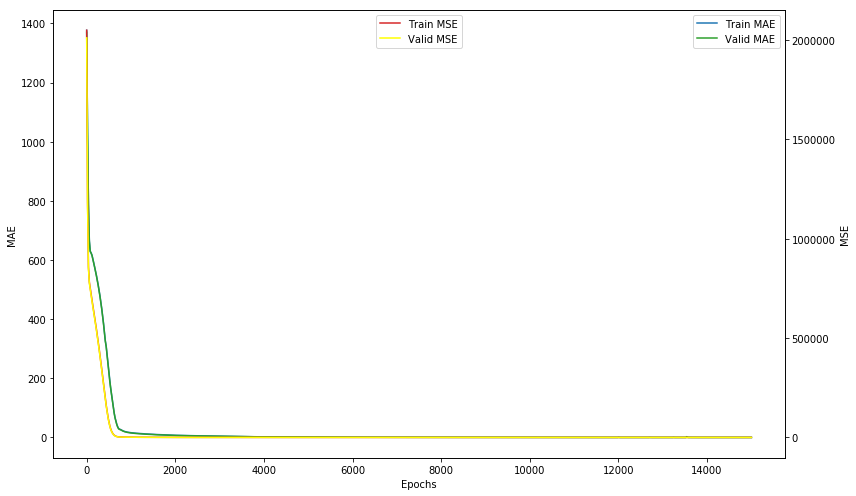

In [33]:
plot_results(train_maes, valid_maes, train_mses, valid_mses, "MAE")

In [38]:
print_results(graph_scaler, scaler_saver, path="./binary_addition_scaler", scales=True)

INFO:tensorflow:Restoring parameters from ./binary_addition_scaler
417 [0 0 0 1 1 0 1 0 0 0 0 1]
+
801 [0 0 1 1 0 0 1 0 0 0 0 1]
=
True: 1218 [0 1 0 0 1 1 0 0 0 0 1 0]
Pred: 1216 [0 1 0 0 1 1 0 0 0 0 0 0]
~~~~~~~~~~
1854 [0 1 1 1 0 0 1 1 1 1 1 0]
+
1503 [0 1 0 1 1 1 0 1 1 1 1 1]
=
True: 3357 [1 1 0 1 0 0 0 1 1 1 0 1]
Pred: 3356 [1 1 0 1 0 0 0 1 1 1 0 0]
~~~~~~~~~~
661 [0 0 1 0 1 0 0 1 0 1 0 1]
+
65 [0 0 0 0 0 1 0 0 0 0 0 1]
=
True: 726 [0 0 1 0 1 1 0 1 0 1 1 0]
Pred: 727 [0 0 1 0 1 1 0 1 0 1 1 1]
~~~~~~~~~~
537 [0 0 1 0 0 0 0 1 1 0 0 1]
+
1683 [0 1 1 0 1 0 0 1 0 0 1 1]
=
True: 2220 [1 0 0 0 1 0 1 0 1 1 0 0]
Pred: 2219 [1 0 0 0 1 0 1 0 1 0 1 1]
~~~~~~~~~~
835 [0 0 1 1 0 1 0 0 0 0 1 1]
+
241 [0 0 0 0 1 1 1 1 0 0 0 1]
=
True: 1076 [0 1 0 0 0 0 1 1 0 1 0 0]
Pred: 1076 [0 1 0 0 0 0 1 1 0 1 0 0]
~~~~~~~~~~
566 [0 0 1 0 0 0 1 1 0 1 1 0]
+
1600 [0 1 1 0 0 1 0 0 0 0 0 0]
=
True: 2166 [1 0 0 0 0 1 1 1 0 1 1 0]
Pred: 2166 [1 0 0 0 0 1 1 1 0 1 1 0]
~~~~~~~~~~
618 [0 0 1 0 0 1 1 0 1 0 1 0]
+
211 [0